## Demand Planning using _EXPERT_

In this notebook, we’ll walk you through how to tackle a common use case: demand forecasting for efficient, data-driven planning. We’ll take demand data from an ERP system, use the *CHECK-IN* in _futureNOW_ to transform raw data into time series, and then let _FORECAST_ make predictions for the next 18 months.


After downloading the dataset from _futureNOW_, we connect to the client using our _future_ username and password.

In [ ]:
from futureexpert import (ExpertClient,
                          ForecastingConfig,
                          MethodSelectionConfig,
                          PreprocessingConfig,
                          ReportConfig)

client = ExpertClient()

INFO:futureexpert.expert_client:Successfully logged in for group group-expert.


## Check in your time series

Check in your time series for _futureEXPERT_ in the [frontend _futureNOW_](https://now.future-forecasting.de/):

1. Navigate to 'My Data' and upload your data
2. Start the _CHECK-IN_ process from a file.
3. Follow along the _CHECK-IN_ steps in the frontend.
4. Copy the version ID.

![copy version from _CHECK-IN_](../../notebooks/img/futureEXPERT_1.png "CHECK-IN")


After defining your _FORECAST_ Configuration in the following step you can then use your checked in data for forecasting in _EXPERT_.



[img/futureEXPERT_1.png]: notebooks/img/futureEXPERT_1.png "CHECK-IN"

### _FORECAST_ Configuration
After checking in our data we are good to perform the forecast update with _FORECAST_. We configure preprocessing, forecasting, and method selection for proper report setup:

**Preprocessing**

- To gain additional insights into our data, we enable the detection of outliers, changepoints, and quantization sizes. Quantization detection also influences forecast generation: forecasts will align with the detected quantization multiples.

**Forecasting**

- We set the `fc_horizon` to 18 months and ensure nonnegative forecasts by applying a `lower_bound` of 0. Any observation below 0 is treated as 0, and forecasts will never fall below this threshold.
- By setting `use_ensemble` to `True`, we allow forecasts to be generated via a linear combination of well-performing methods. This ensemble, however, must compete with individual models during method selection and is not guaranteed to provide the final forecast.
- Prediction intervals are enabled with a confidence level of 0.75 (75%), and forecasts are rounded to integers, as demand is measured in whole units.

**Method Selection**

- Forecasting methods are chosen based on 18 backtesting iterations, with models being refitted for each round. During backtesting, we prioritize forecast steps three and four (`step_weights`: 100%), while steps five and contribute only 50% to the scoring. Steps before three and beyond six are excluded from the selection process.
- Additional accuracy metrics, such as mean error and mean absolute error, offer deeper insights into model performance but do not affect selection. The default metrics for model evaluation are mean squared error and periods in stock (for sporadic time series).

Additionally, we use a `max_ts_len` of 72 instead of the default 86 for monthly data, which means that for every time series, only a the last 72 observations is used by _FORECAST_. This increases performance a bit while having little impact on the quality of the results.

In [ ]:
fc_report_config = ReportConfig(
    title='Monthly Demand Forecast on Material Level NOW+EXPERT',
    preprocessing=PreprocessingConfig(remove_leading_zeros=True,
                                      detect_outliers=True,
                                      replace_outliers=True,
                                      detect_changepoints=True,
                                      detect_quantization=True),
    forecasting=ForecastingConfig(fc_horizon=18,
                                  lower_bound=0,
                                  use_ensemble=True,
                                  confidence_level=0.75,
                                  round_forecast_to_integer=True),
    method_selection=MethodSelectionConfig(number_iterations=18,
                                           refit=True,
                                           step_weights={3:1, 4:1, 5:0.5, 6:0.5},
                                           additional_accuracy_measures=['me', 'mae']),
    max_ts_len=72)


INFO:futureexpert.expert_client:Preparing data for forecast...
INFO:futureexpert.expert_client:Finished data preparation for forecast.
INFO:futureexpert.expert_client:Started creating forecasting report with FORECAST...
INFO:futureexpert.expert_client:Finished report creation. Forecasts are running...


## Invoke forecast computation

Computing the forecasting results takes some time depending on the number of time series and the configuration. The computation of the results is therefore an asynchoronous operation which does not block your Python environment. Let's watch the status of the forecast computation before accessing the results.

In [ ]:
ts_version = 'TBD' # replace with your version

# Request forecast creation and retrieve the id for status requests and result retrieval
forecast_identifier = client.start_forecast(version=ts_version, config=fc_report_config)

INFO:futureexpert.expert_client:Preparing data for forecast...
INFO:futureexpert.expert_client:Finished data preparation for forecast.
INFO:futureexpert.expert_client:Started creating forecasting report with futureFORECAST...
INFO:futureexpert.expert_client:Finished report creation. Forecasts are running...


In [ ]:
import time

# Watch the current status of the forecasting report
while not (current_status := client.get_report_status(id=forecast_identifier)).is_finished:
    current_status.print()
    print('Waiting another 30 seconds to finish forecasting...')
    time.sleep(10)  # Wait between status requests
    
current_status.print()

# Retrieve the results of the forecasting report
results = client.get_fc_results(id=forecast_identifier, include_backtesting=True, include_k_best_models=3)

Status forecasting report for id: report_id=19573 settings_id=19581
 0 % are finished 
 3 time series requested for calculation 
 0 time series finished 
 0 time series without evaluation 
 0 time series ran into an error
Waiting another 30 seconds to finish forecasting...
Status forecasting report for id: report_id=19573 settings_id=19581
 0 % are finished 
 3 time series requested for calculation 
 0 time series finished 
 0 time series without evaluation 
 0 time series ran into an error
Waiting another 30 seconds to finish forecasting...
Status forecasting report for id: report_id=19573 settings_id=19581
 0 % are finished 
 3 time series requested for calculation 
 0 time series finished 
 0 time series without evaluation 
 0 time series ran into an error
Waiting another 30 seconds to finish forecasting...
Status forecasting report for id: report_id=19573 settings_id=19581
 33 % are finished 
 3 time series requested for calculation 
 1 time series finished 
 0 time series without 

### Results Retrieval and Inspection of Results

Once forecasts are generated, we retrieve the results from the database using the identifier. For each material, we include the top three models and their backtesting results.

For each time series, we review an overview of key details, including the selected forecasting method, the best-performing model, the time series class, and other relevant characteristics.

In [5]:
from futureexpert.forecast import export_result_overview_to_pandas
export_result_overview_to_pandas(results)

,name,Material,model,cov,cov_lag,season_length,ts_class,quantization,trend,recent_trend,missing_values_count,outliers_count
0,Demand-C024897037,C024897037,AutoEsCov,NaN,NaN,[12],smooth,6.0,False,True,NaN,NaN
1,Demand-C023019522,C023019522,InterpolID,NaN,NaN,[12],intermittent,6.0,False,True,NaN,NaN
2,Demand-C010825983,C010825983,SVM,NaN,NaN,[6],lumpy,24.0,False,True,NaN,NaN
3,Demand-C011414575,C011414575,Ensemble,NaN,NaN,[1],smooth,78.0,False,True,NaN,NaN
4,Demand-C026568362,C026568362,Glmnet(l1_ratio=1.0),NaN,NaN,[12],smooth,6.0,False,False,NaN,NaN
5,Demand-C048097345,C048097345,TBATS,NaN,NaN,[12],smooth,6.0,False,True,NaN,NaN
6,Demand-C048529686,C048529686,MedianAS,NaN,NaN,[12],smooth,6.0,False,False,NaN,NaN
7,Demand-C031595988,C031595988,AutoEsCov,NaN,NaN,[1],smooth,12.0,False,NaN,NaN,NaN
8,Demand-C021120183,C021120183,Croston,NaN,NaN,[3],lumpy,6.0,False,True,NaN,NaN
9,Demand-C018904994,C018904994,SVM,NaN,NaN,[3],lumpy,6.0,False,True,NaN,NaN


Now we take a look at the visualized forecasts. We limit the actuals to the last 6 years by setting `plot_last_x_data_points_only=72` to match the data we used for the analyses and focus only on the best model by specifying the rank list as `[1]`. Additionally, we analyze outliers and changepoints, including time windows with sparse observations. This information helps us gain deeper insights into the data and forecasts, allowing us to make the best possible decisions.

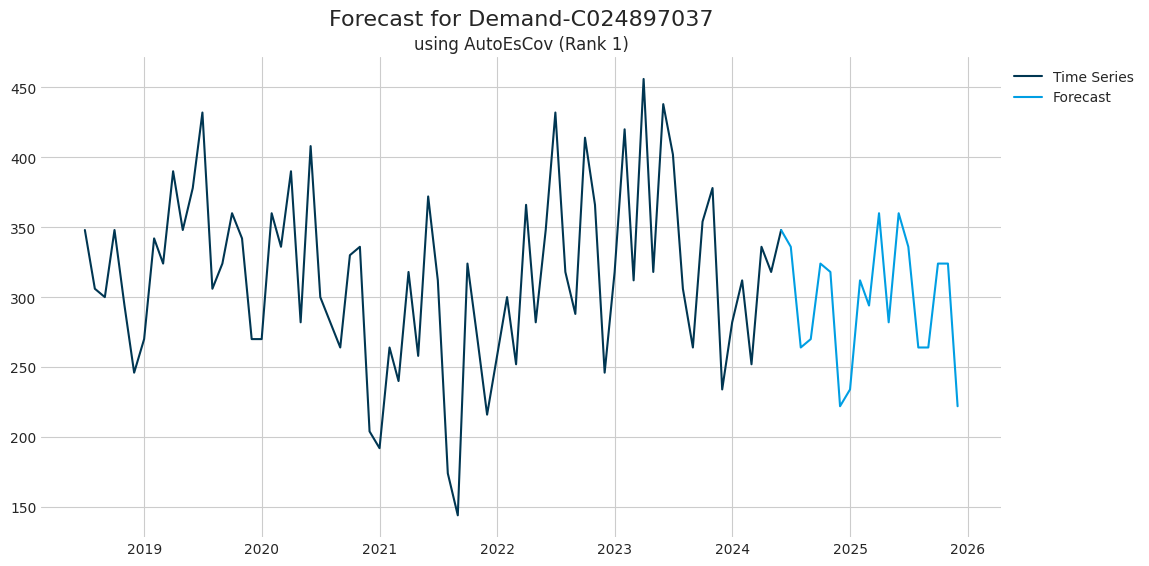

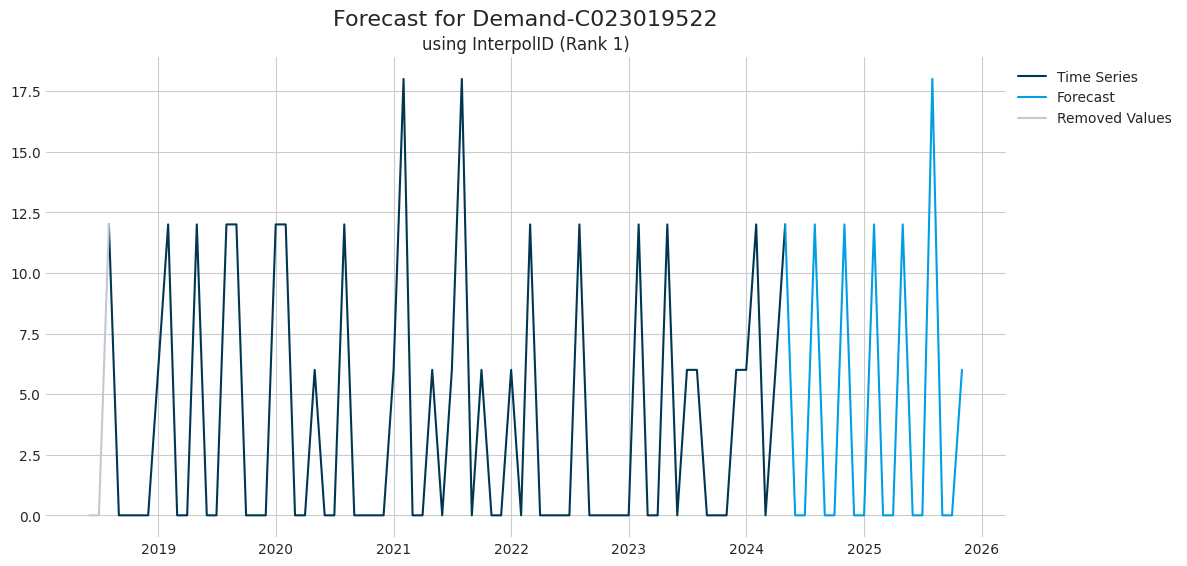

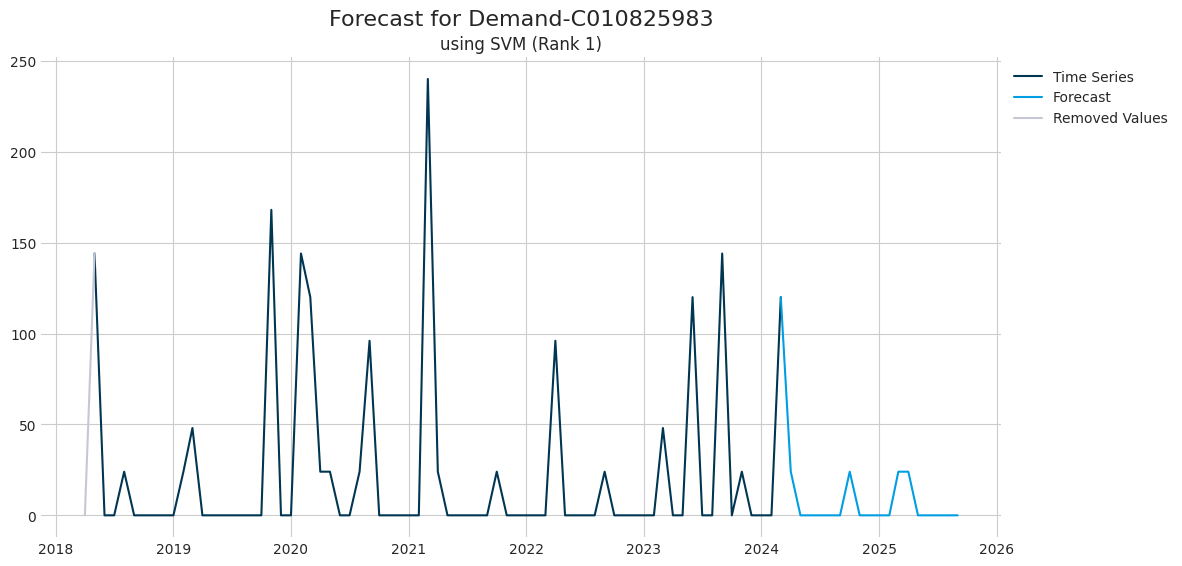

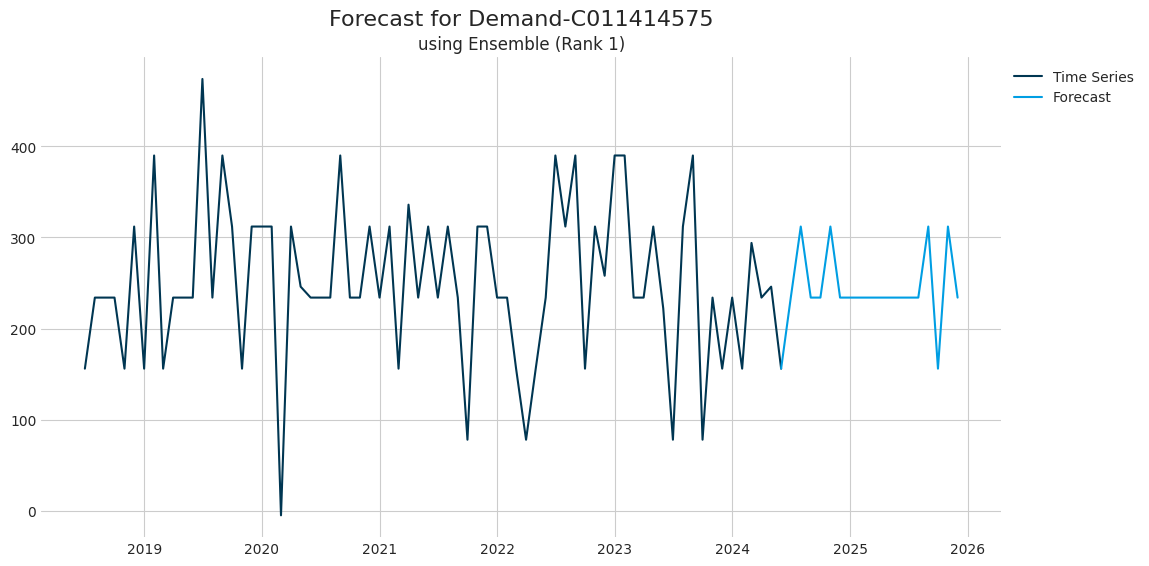

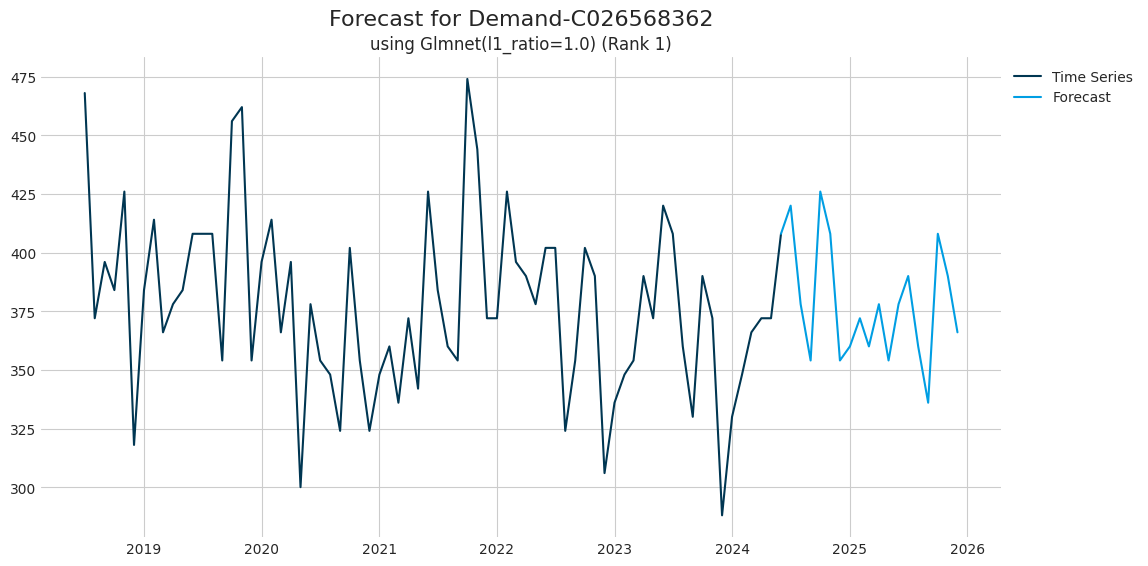

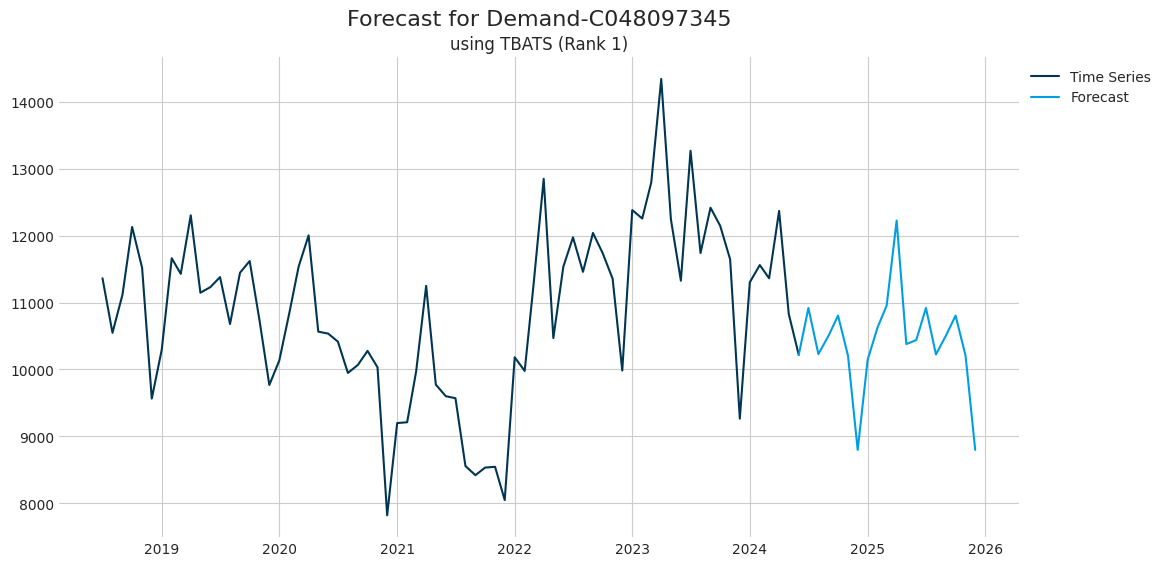

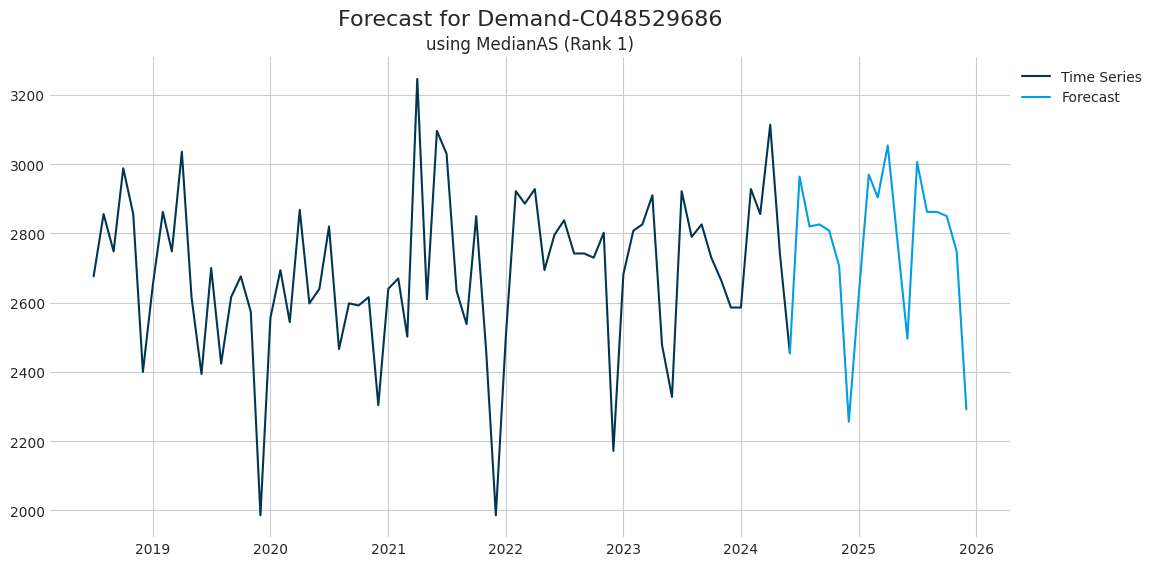

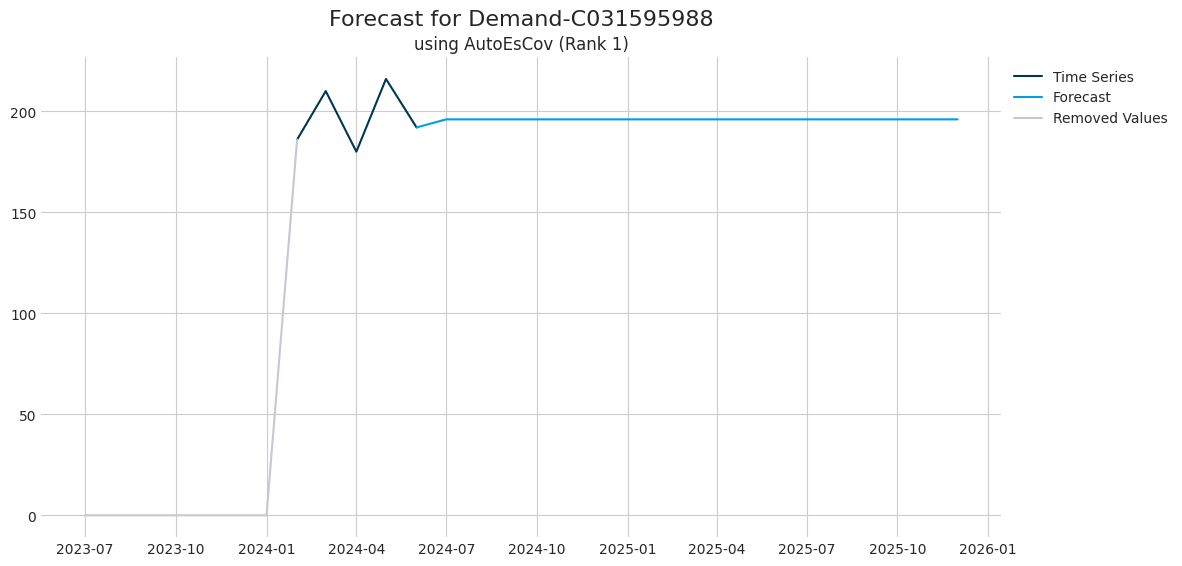

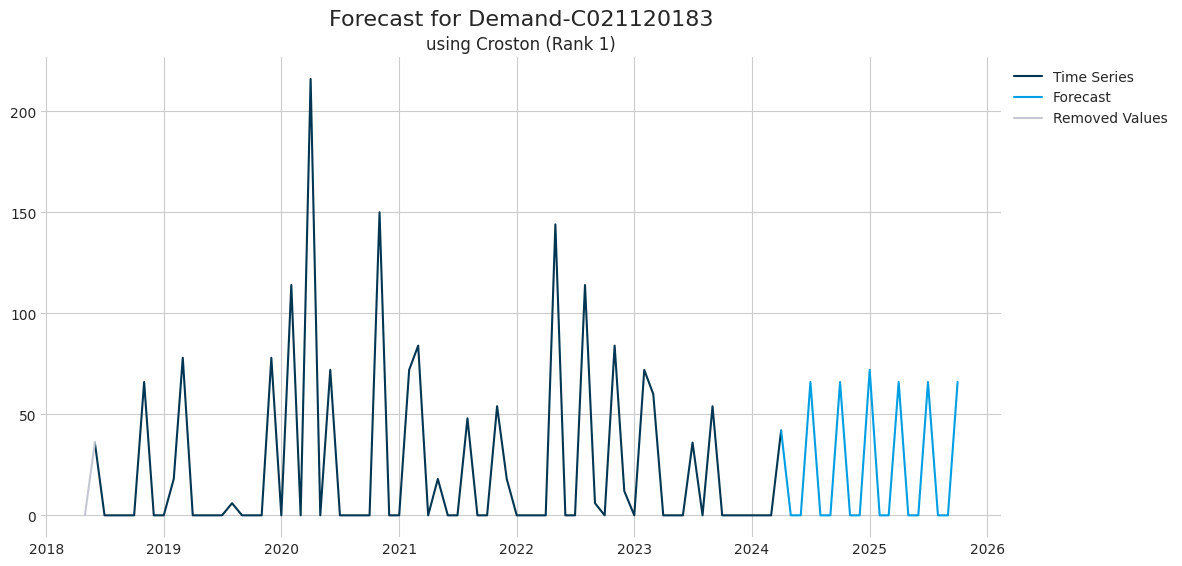

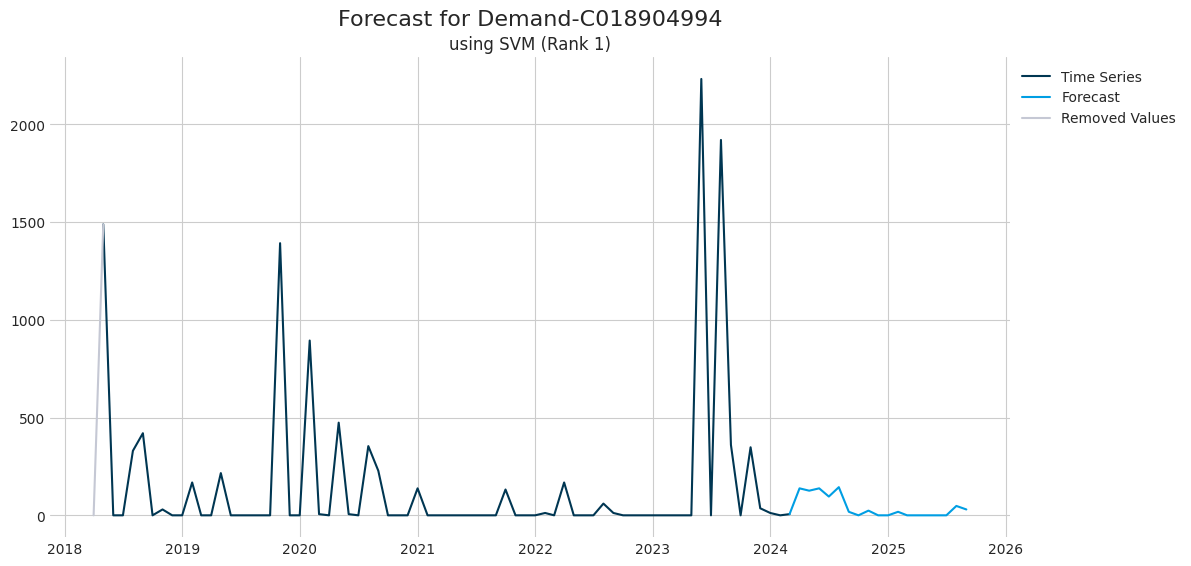

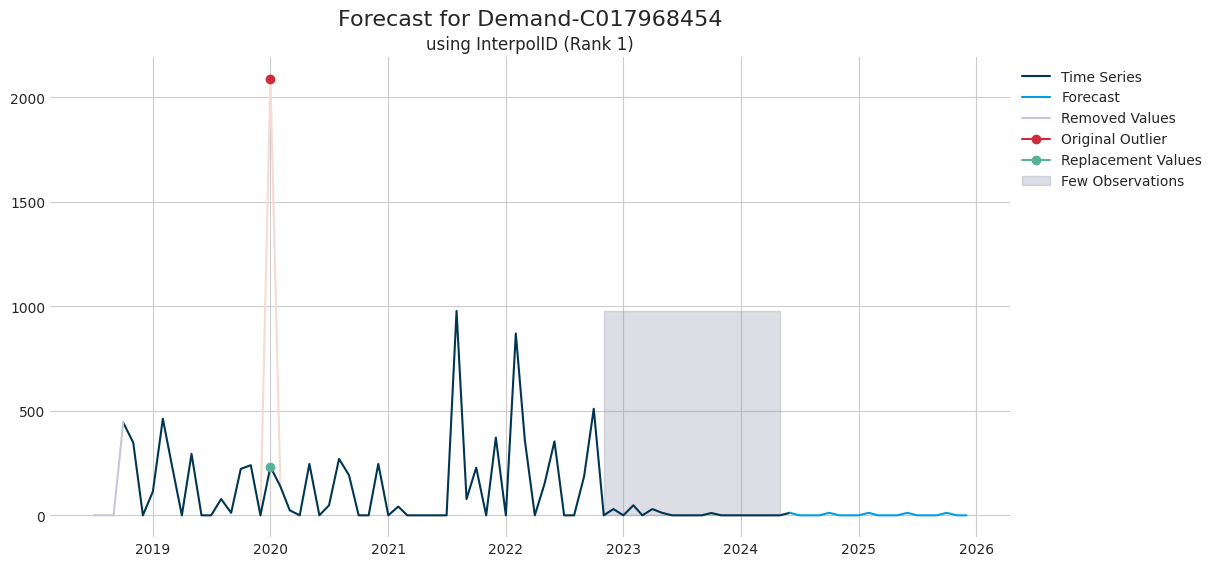

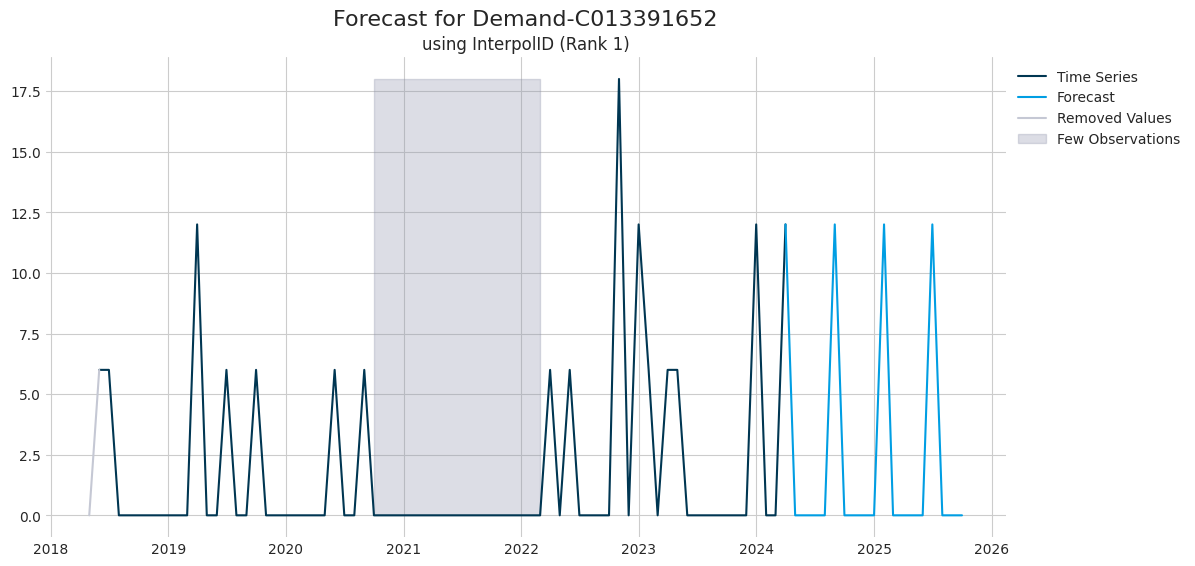

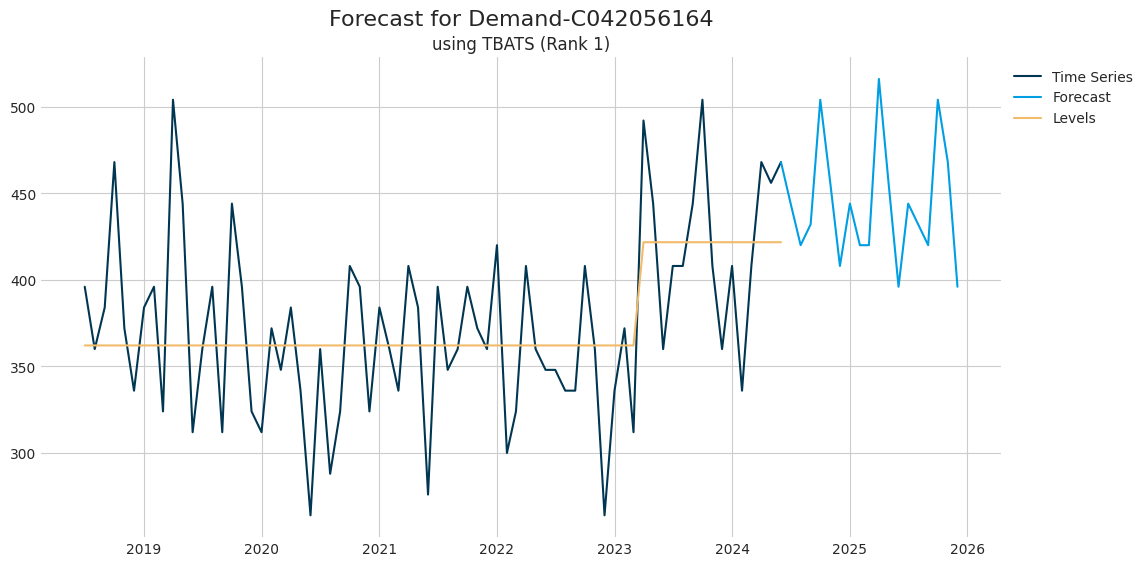

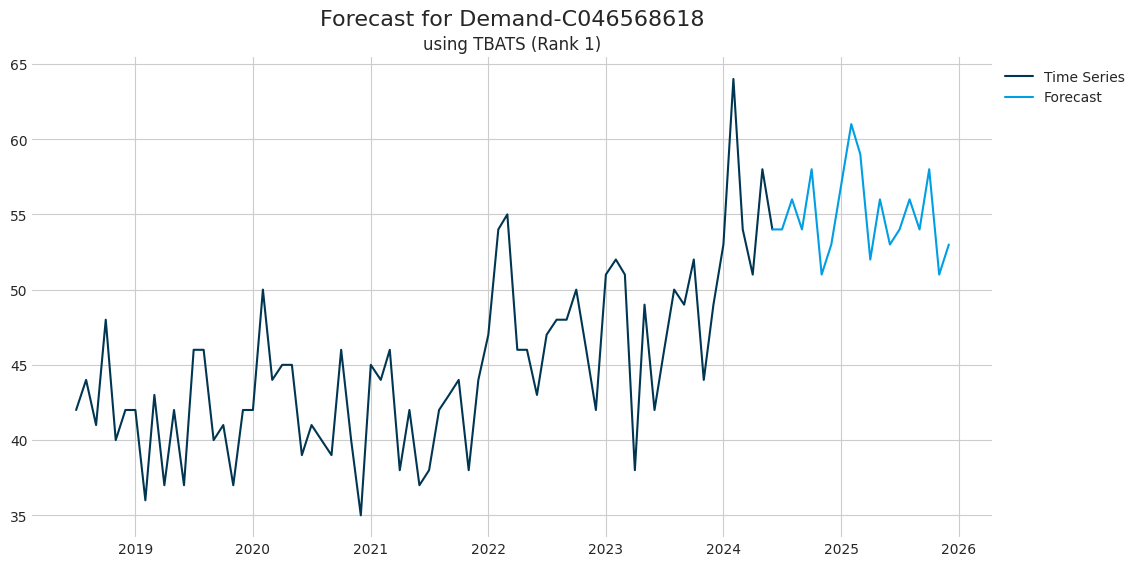

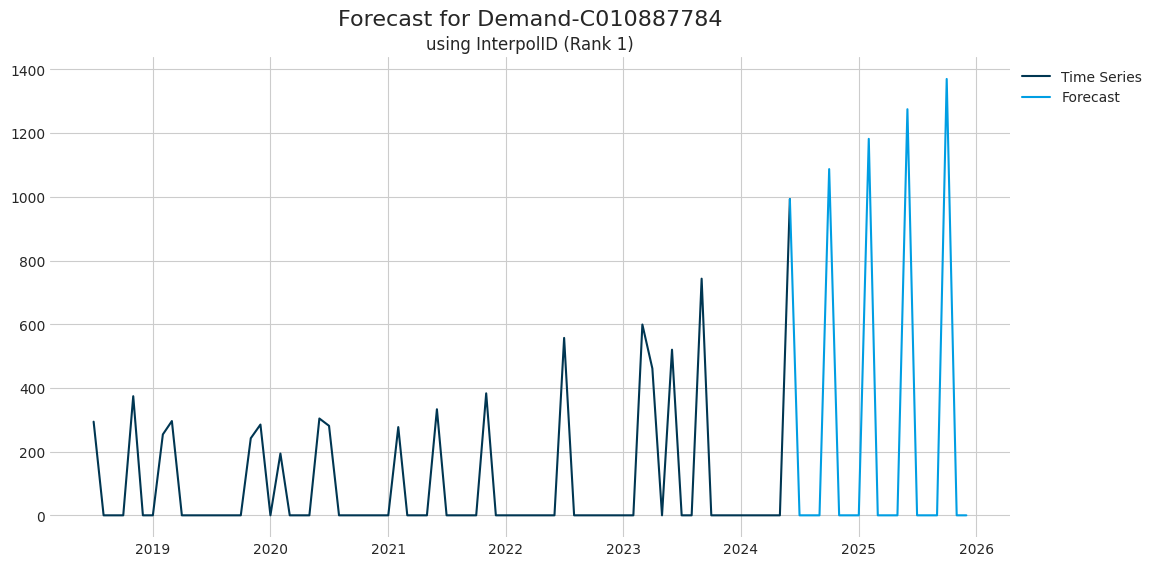

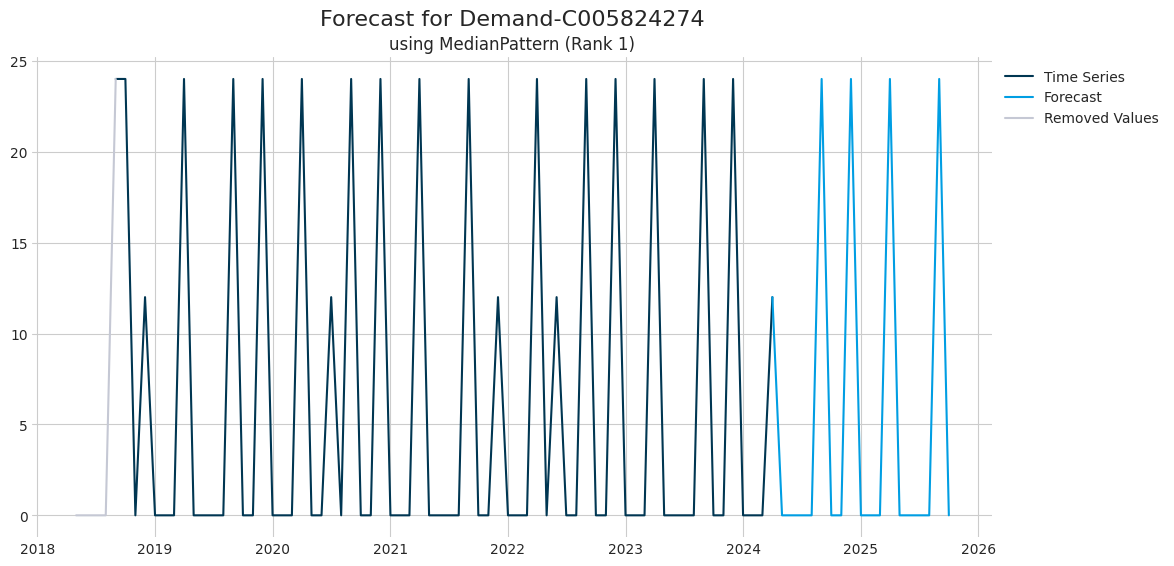

In [6]:
from futureexpert import plot
for ts in results:
    plot.plot_forecast(ts, plot_last_x_data_points_only=72, ranks=[1], plot_prediction_intervals=False,
                       plot_outliers=True, plot_change_points=True)
